# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski [2.5 pkt]
4. Jakość kodu [0.5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [3]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np
import matplotlib.pyplot as plt


Seed: 200, number of layers: 3, hidden layer size: 16 
Epoch 0/500, Loss: 0.1000
Epoch 50/500, Loss: 0.0899
Epoch 100/500, Loss: 0.0879
Epoch 150/500, Loss: 0.0852
Epoch 200/500, Loss: 0.0808
Epoch 250/500, Loss: 0.0754
Epoch 300/500, Loss: 0.0706
Epoch 350/500, Loss: 0.0671
Epoch 400/500, Loss: 0.0645
Epoch 450/500, Loss: 0.0624
Accuracy: 66.67%
Seed: 200, number of layers: 3, hidden layer size: 64 
Epoch 0/500, Loss: 0.1004
Epoch 50/500, Loss: 0.0877
Epoch 100/500, Loss: 0.0834
Epoch 150/500, Loss: 0.0773
Epoch 200/500, Loss: 0.0706
Epoch 250/500, Loss: 0.0652
Epoch 300/500, Loss: 0.0612
Epoch 350/500, Loss: 0.0580
Epoch 400/500, Loss: 0.0554
Epoch 450/500, Loss: 0.0532
Accuracy: 76.51%
Seed: 200, number of layers: 3, hidden layer size: 256 
Epoch 0/500, Loss: 0.0999
Epoch 50/500, Loss: 0.0805
Epoch 100/500, Loss: 0.0709
Epoch 150/500, Loss: 0.0631
Epoch 200/500, Loss: 0.0579
Epoch 250/500, Loss: 0.0545
Epoch 300/500, Loss: 0.0520
Epoch 350/500, Loss: 0.0501
Epoch 400/500, Loss: 0.04

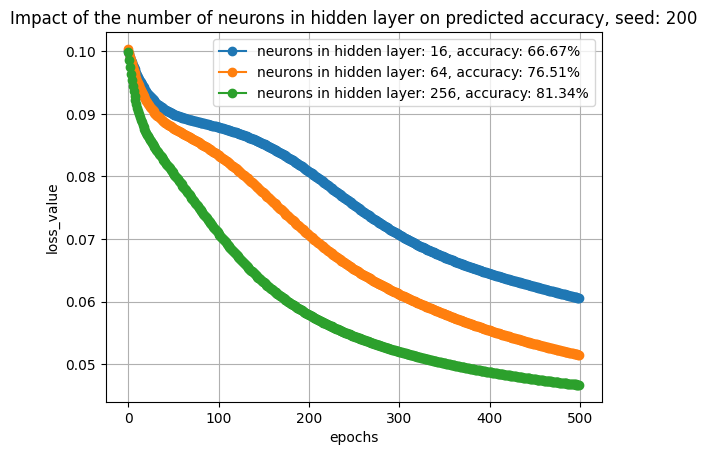

In [6]:

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x: np.ndarray) -> np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative) -> np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate


class FullyConnected(Layer):
    def __init__(self, input_size: int, output_size: int) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        weight_multiplier = 0.01
        self.weights = np.random.randn(input_size, output_size) * weight_multiplier
        self.biases = np.zeros((1, output_size))
        self.input = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        return np.dot(x, self.weights) + self.biases

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
        weights_gradient = np.dot(self.input.T, output_error_derivative)
        biases_gradient = np.sum(output_error_derivative, axis=0, keepdims=True)
        self.weights -= self.learning_rate * weights_gradient
        self.biases -= self.learning_rate * biases_gradient
        return np.dot(output_error_derivative, self.weights.T)


class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.output = np.tanh(x)
        return self.output

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
        return output_error_derivative * (1 - self.output ** 2)


class Loss:
    def __init__(self, loss_function: callable, loss_function_derivative: callable) -> None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Loss function for a particular x and y"""
        return self.loss_function(x, y)

    def loss_derivative(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Loss function derivative for a particular x and y"""
        return self.loss_function_derivative(x, y)


class Network:
    def __init__(self, layers: List[Layer], learning_rate: float) -> None:
        self.layers = layers
        self.learning_rate = learning_rate

    @staticmethod
    def mean_squared_error_loss(y_real: np.ndarray, y_predicted: np.ndarray) -> np.ndarray:
        """Oblicza stratę przy użyciu funkcji straty średniokwadratowej (MSE)."""
        return np.mean((y_real - y_predicted) ** 2)

    @staticmethod
    def mean_squared_error_loss_derivative(y_real: np.ndarray, y_predicted: np.ndarray) -> np.ndarray:
        """Oblicza pochodną funkcji straty średniokwadratowej."""
        return 2 * (y_predicted - y_real) / y_real.shape[0]

    def compile(self, loss: Loss) -> None:
        """Define the loss function and loss function derivative"""
        self.loss_function = loss.loss_function
        self.loss_function_derivative = loss.loss_function_derivative

    def __call__(self, x: np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def fit(self,
            x_train: np.ndarray,
            y_train: np.ndarray,
            epochs: int,
            learning_rate:float,
            verbose: int = 0) -> tuple[list[float], list[int]]:
        """Fit the network to the training data"""
        loss_values = []
        epoch_values = []
        for epoch in range(epochs):
            y_predict = self(x_train)
            loss = self.loss_function(y_train, y_predict)
            loss_derivative = self.loss_function_derivative(y_train, y_predict)
            loss_values.append(loss)
            epoch_values.append(epoch)
            for layer in reversed(self.layers):
                loss_derivative = layer.backward(loss_derivative)
            if verbose > 0 and epoch % (epochs / 10) == 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")
        return loss_values, epoch_values


def load_data_form_MNIST(seed: int):
    mnist = fetch_openml('mnist_784', version=1)
    X = mnist.data.astype(np.float32)
    Y = mnist.target.astype(np.int32)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

    X_train /= 255.0
    X_test /= 255.0
    NUMBER_OF_CLASSES = 10
    Y_train = one_hot_encode(Y_train, NUMBER_OF_CLASSES)
    return X_train, X_test, Y_train, Y_test


def one_hot_encode(y, num_classes):
    encoded = np.zeros((y.size, num_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded


def experiment(seed: int, hidden_layer_size: int, epochs_number: int) -> tuple[list[int], list[float], float]:
    X_train, X_test, Y_train, Y_test = load_data_form_MNIST(seed)
    layers = [
        FullyConnected(input_size=784, output_size=hidden_layer_size),
        Tanh(),
        FullyConnected(input_size=hidden_layer_size, output_size=10)
    ]
    model = Network(layers=layers, learning_rate=0.01)
    loss = Loss(
        loss_function=Network.mean_squared_error_loss,
        loss_function_derivative=Network.mean_squared_error_loss_derivative
    )
    print(f"Seed: {seed}, number of layers: {len(layers)}, hidden layer size: {hidden_layer_size} ")
    model.compile(loss)
    loss_values, epoch_values = model.fit(X_train, Y_train, epochs=epochs_number, learning_rate=0.01, verbose=1)
    predictions = model(X_test)
    predicted_classes = np.argmax(predictions, axis=1)
    accuracy = np.mean(predicted_classes == Y_test) * 100
    accuracy = round(accuracy, 2)
    print(f"Accuracy: {accuracy}%")
    return loss_values, epoch_values, accuracy


def generate_plot(loss_values_all: list[list[float]], epoch_values: list[int], acurracies_all: list[float], seed: int, hidden_layers: list[int]):
    name = f"Impact of the number of neurons in hidden layer on predicted accuracy, seed: {seed}"
    for index, loss_values in enumerate(loss_values_all):
        plt.plot(epoch_values[index], loss_values, label = f"neurons in hidden layer: {hidden_layers[index]}, accuracy: {acurracies_all[index]}%", marker="o")
        plt.legend()
    plt.title(name)
    plt.xlabel("epochs")
    plt.ylabel("loss_value")
    plt.grid()
    plt.savefig(f"plot.png")
    plt.show()



def main():
    SEED = 200
    HIDDEN_LAYERS = [16, 64, 256]
    EPOCHS = 100
    loss_values_all = []
    epoch_values_all = []
    acurracies_all = []
    for hidden_layer in HIDDEN_LAYERS:
        loss_values, epoch_values, accuracy = experiment(SEED, hidden_layer, EPOCHS)
        loss_values_all.append(loss_values)
        epoch_values_all.append(epoch_values)
        acurracies_all.append(accuracy)
    generate_plot(loss_values_all, epoch_values_all, acurracies_all, SEED, HIDDEN_LAYERS)



if __name__ == "__main__":
    main()


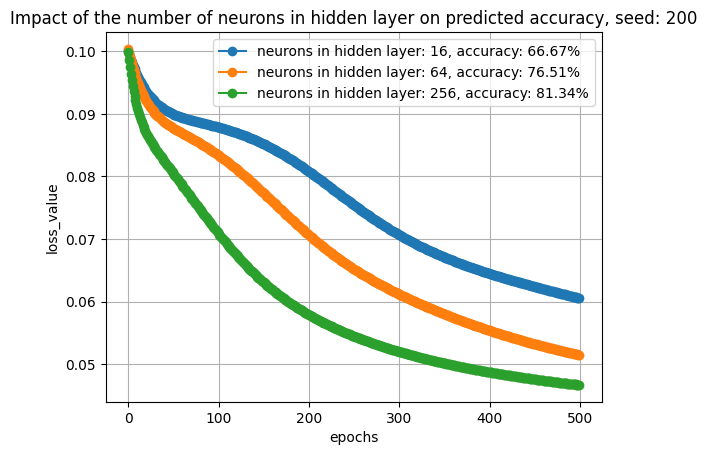

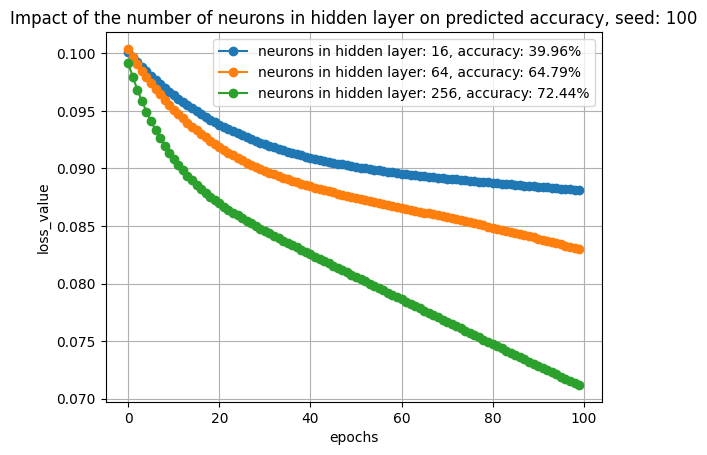

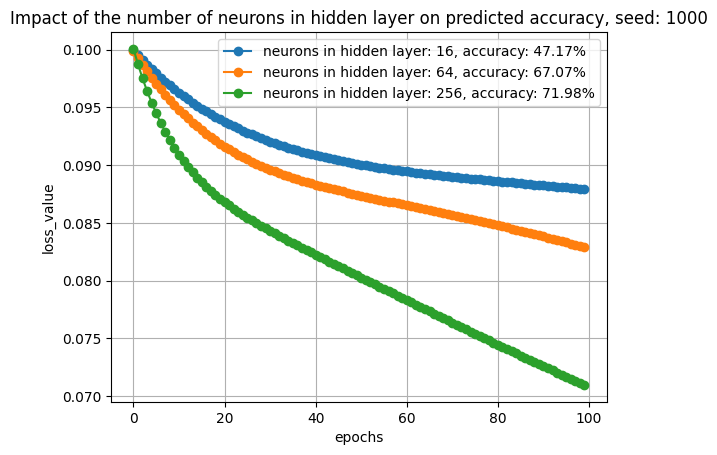

# Eksperymenty

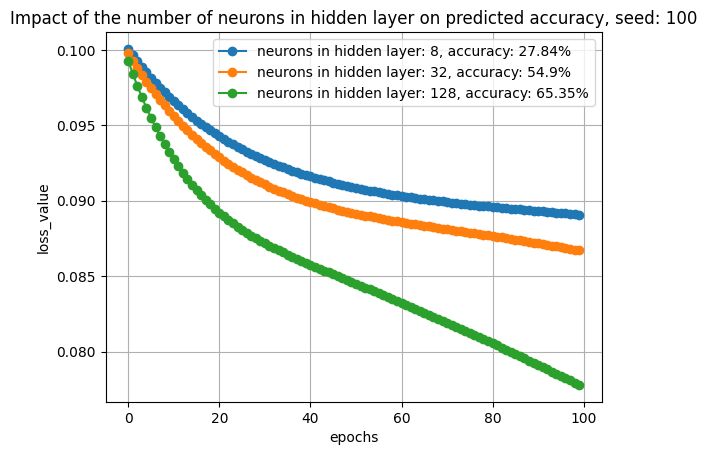

# Wnioski

W doświadczeniach wykorzystałem sztuczną sieć neuronową o 3 warstwach.Zauważyłem, że ilość neuronów w warstwie ukrytej ma wpływ na
badaną dokładność, jest ona wyższa dla większej ilości neuronów w wartwie ukrytej. Czynnikiem mającym również duże znaczenie na dokładność 
wyniku jest liczba epok, przez które program przechodzi.